In [1]:
import matplotlib.pyplot as plt
import PIL
from mpl_interactions import ioff, panhandler, zoom_factory
from PIL import Image

In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from segger_tracker import SeggerTracker
import ncolor
import glob

In [3]:
def find_skeleton_centers(cell_count, gradient_total, threshold, regs_label):
    centers = {}
    for i in range(cell_count+1):
        masked = (regs_label == i) & (gradient_total < threshold)
        if not np.any(masked):
            continue
        #Skeleton of this cell
        y = np.ma.array(gradient_total * masked)
        row_indices, col_indices = np.where(y < 0)
        if(len(row_indices)<1):
            original_field = (regs_label == i)
            row_indices, col_indices = np.ma.where(original_field)
        #Find the geomerty center
        x_center = np.mean(row_indices)
        y_center = np.mean(col_indices)
        #Projected the geomerty center on skeleton
        distances = np.sqrt((row_indices - x_center)**2 + (col_indices - y_center)**2)
        closest_index = np.argmin(distances)
        closest_point = (row_indices[closest_index], col_indices[closest_index])
        #Found skeleton center
        centers[SeggerTracker.compress_xy(closest_point[1], closest_point[0])] = i
        
    return centers

In [58]:
npy_path = "/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/phase/211121_37C_10_1176_HU_timelapse002_prob211203_HU_t00028xy0c1_seg.npy"
dat = np.load(npy_path, allow_pickle=True).item()
gradientsx = np.gradient(dat['flows'][-1][0])
gradientsy = np.gradient(dat['flows'][-1][1])
gradient_total = gradientsy[1] + gradientsx[0]

regs_label = dat['masks']
cell_num = np.max(regs_label)
centers = find_skeleton_centers(cell_num, gradient_total, -3, regs_label)

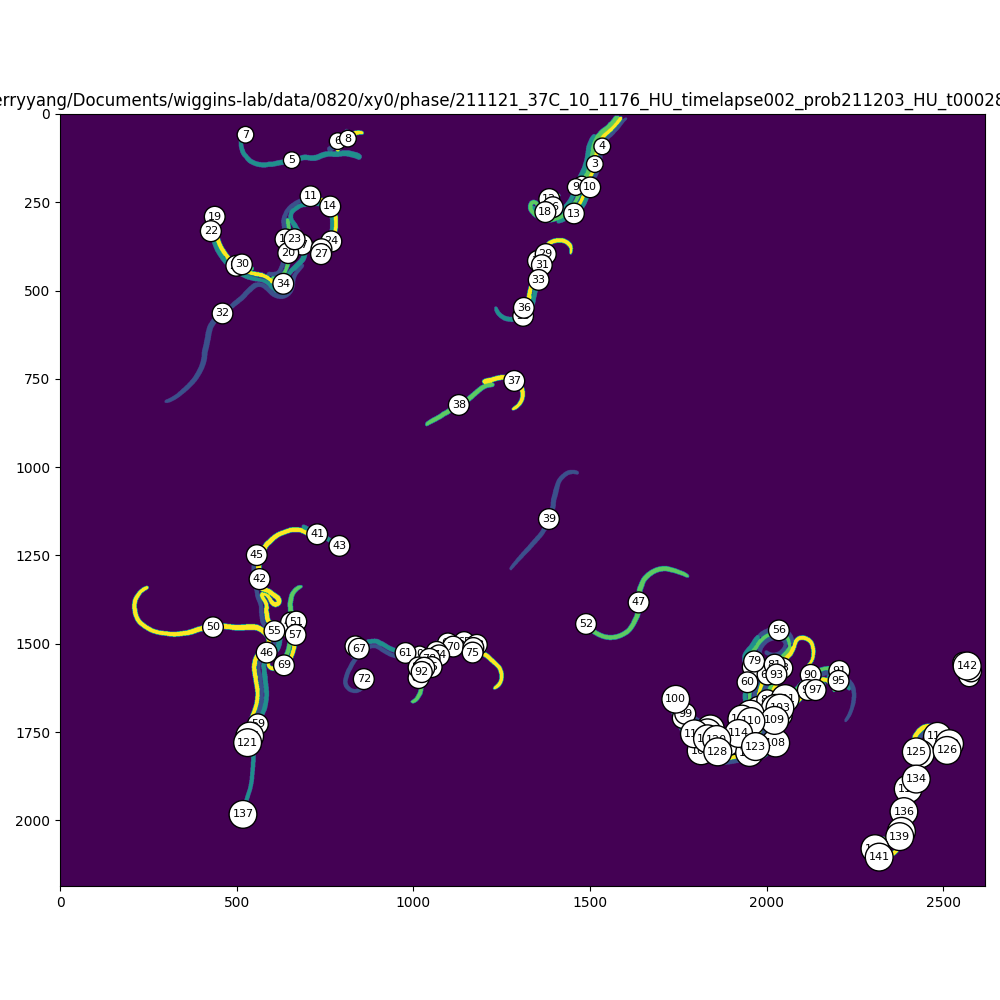

In [59]:
ncolor_masks = ncolor.label(regs_label)
%matplotlib widget

plt.ioff()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ncolor_masks)
fig.tight_layout()
plt.title(npy_path)

# Iterate through the dictionary and draw circles with labels
for position, label in centers.items():
    x, y = SeggerTracker.extract_xy(position)
    ax.text(x, y, str(label), color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'), fontsize=8, horizontalalignment='center', verticalalignment='center')


disconnect_zoom = zoom_factory(ax)
display(fig.canvas)